<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/Misc/cyclegan_horse_zebra_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN demo: pretrained horse-zebra model
From https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch2/3_cyclegan.ipynb

In [1]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [2]:
netG = ResNetGenerator()

In [15]:
# delete any old model paths
!rm *.pth. 

In [16]:


!wget -c https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse2zebra_0.4.0.pth?raw=true -O horse2zebra.pth


--2021-03-07 06:12:43--  https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse2zebra_0.4.0.pth?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse2zebra_0.4.0.pth [following]
--2021-03-07 06:12:43--  https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse2zebra_0.4.0.pth
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse2zebra_0.4.0.pth [following]
--2021-03-07 06:12:43--  https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse2zebra_0.4.0.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.11

In [17]:
model_path = 'horse2zebra.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [18]:
netG.eval();

In [19]:
from PIL import Image
from torchvision import transforms

In [20]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

In [40]:

url = "https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse.jpg?raw=true" 
!wget $url -O horse.jpg

--2021-03-07 06:22:23--  https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse.jpg [following]
--2021-03-07 06:22:23--  https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse.jpg [following]
--2021-03-07 06:22:23--  https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to r

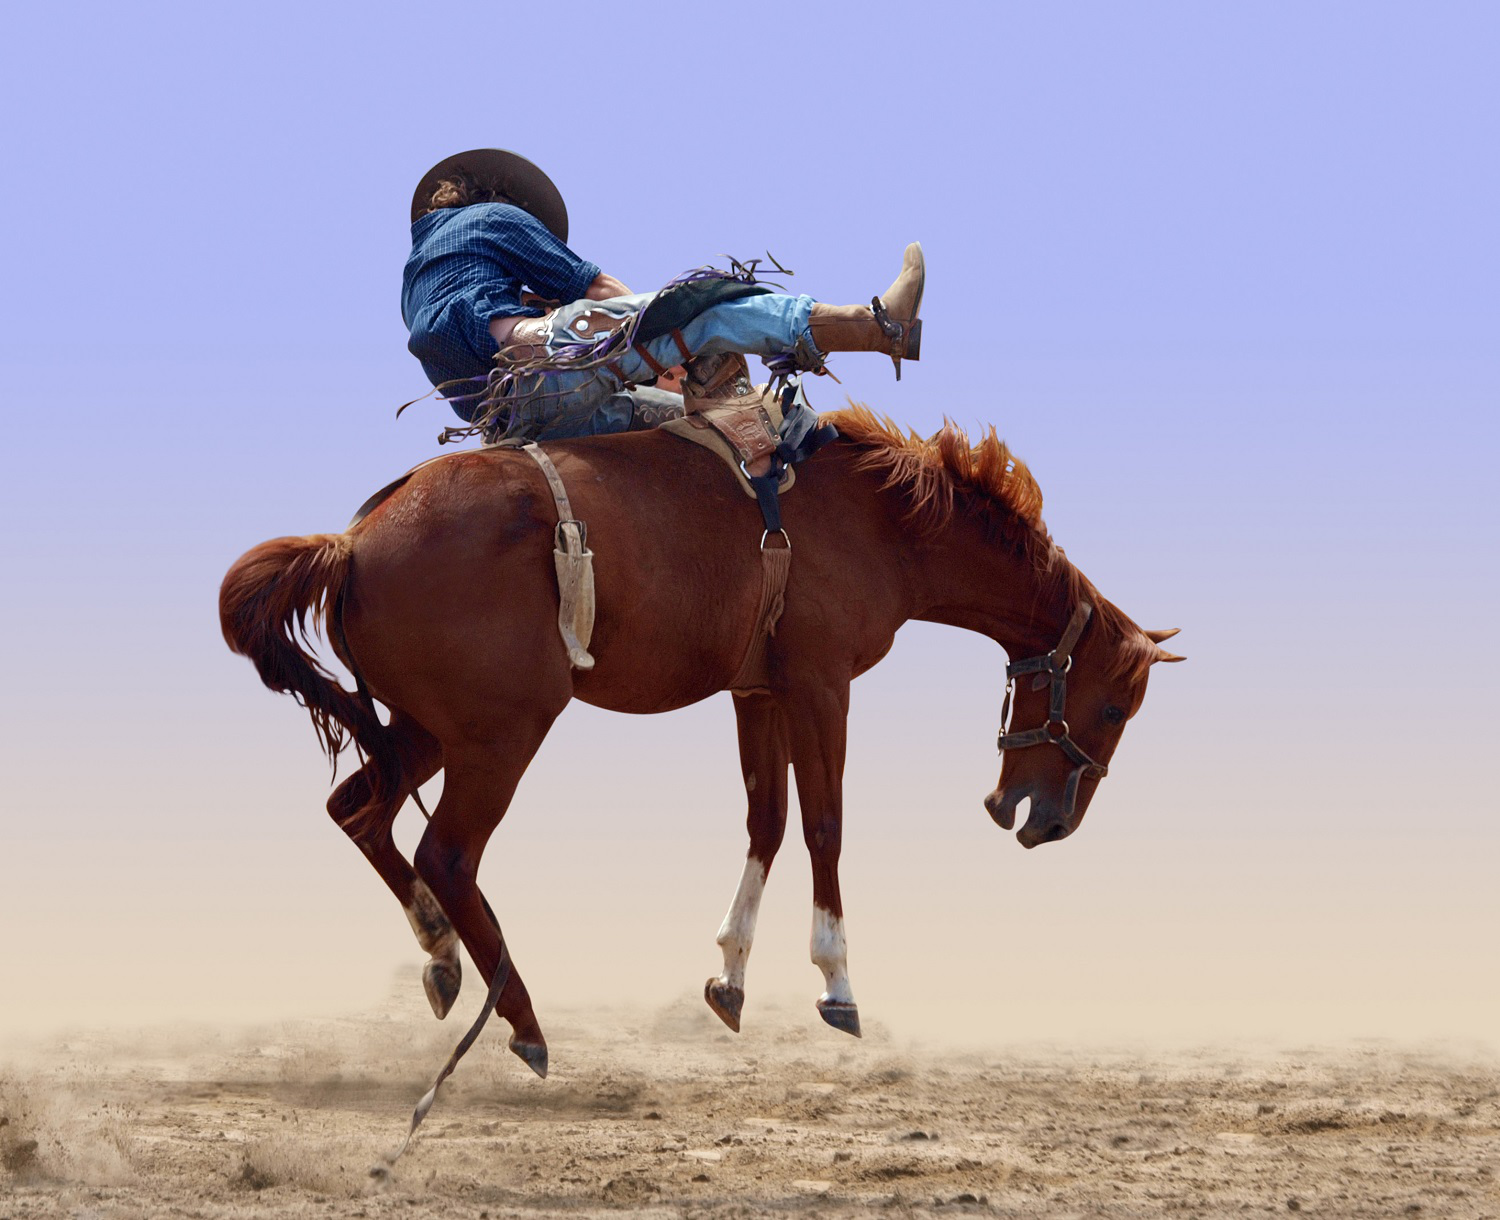

In [41]:
img = Image.open('horse.jpg')
display(img)

In [33]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)
batch_t.shape

torch.Size([1, 3, 256, 314])

In [34]:
batch_out = netG(batch_t)
batch_out.shape

torch.Size([1, 3, 256, 316])

In [37]:
out = batch_out.data.squeeze()
print(type(out))
print(out.shape)
print(torch.min(out), torch.max(out))

<class 'torch.Tensor'>
torch.Size([3, 256, 316])
tensor(-0.9926) tensor(0.9910)


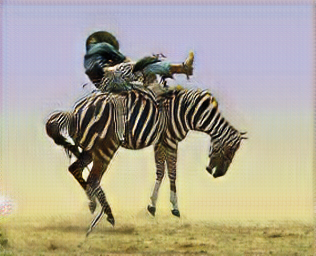

In [38]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0 #-1..1 to 0..1
out_img = transforms.ToPILImage()(out_t)
out_img